In [34]:
!pip install matplotlib


You should consider upgrading via the '/home/nina/Schreibtisch/HCI/Projekt/venv/bin/python -m pip install --upgrade pip' command.


Accuracy: 0.759

 Confusion Matrix:
 [[17 20]
 [12 84]]

 Classification Report:
               precision    recall  f1-score   support

         0.0       0.59      0.46      0.52        37
         1.0       0.81      0.88      0.84        96

    accuracy                           0.76       133
   macro avg       0.70      0.67      0.68       133
weighted avg       0.75      0.76      0.75       133



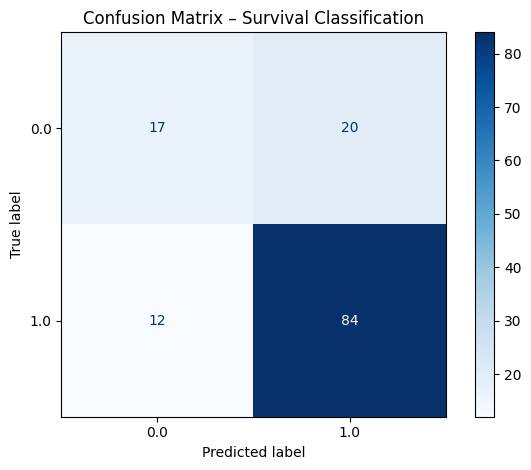

In [35]:
# 📦 Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression



clinical_data = pd.read_csv("hcai_data-main/difg_glass_clinical_data.tsv", sep="\t")

# 🧠 2. Zielvariable (Survival_Class) extrahieren aus "0:LIVING" / "1:DECEASED"
def extract_survival_class(val):
    try:
        return int(str(val).split(":")[0])  # nimmt 0 oder 1
    except:
        return np.nan

clinical_data["Survival_Class"] = clinical_data["Overall Survival"].apply(extract_survival_class)

#Survival_Class -> targer 
# 
cols = [
    "Survival_Class", "Age", "Radiation Dose",
    "TMZ Treatment", "Radiotherapy Treatment",
    "Concurrent TMZ Treatment", "Cancer Type", "Cancer Type Detailed"
]
df = clinical_data[cols].copy()

# handle nan values
df = df.dropna(subset=["Survival_Class"])
df["Age"] = df["Age"].fillna(df["Age"].median())
df["Radiation Dose"] = df["Radiation Dose"].fillna(0)

# 🔁 5. Kategorische Variablen in numerische (One-Hot-Encoding)
df_encoded = pd.get_dummies(df,
    columns=["TMZ Treatment", "Radiotherapy Treatment", "Concurrent TMZ Treatment",
             "Cancer Type", "Cancer Type Detailed"],
    drop_first=True
)

# 📊 6. Feature-Matrix (X) und Zielvariable (y) trennen
X = df_encoded.drop(columns=["Survival_Class"]) #feature matrix
y = df_encoded["Survival_Class"] #target


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# train - random forest
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)


y_pred = model.predict(X_test)

#train - logic regression
log_model = LogisticRegression(max_iter=1000, class_weight="balanced", random_state=42)
log_model.fit(X_train, y_train)
y_pred_log = log_model.predict(X_test)

print("Accuracy:", round(accuracy_score(y_test, y_pred), 3))
print("\n Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\n Classification Report:\n", classification_report(y_test, y_pred))

# visualize
ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, cmap='Blues')
plt.title("Confusion Matrix – Survival Classification")
plt.tight_layout()
plt.show()

# f1 score für verstorbene ziemlich gut (0.84)
# f1 Wert für lebende Patienten ausbaufähig (0.52)
# gesamtaccuracy ok
# modell erkennt lebende patienten noch schlecht



print(" Logistic Regression Ergebnisse")
print(" Accuracy:", round(accuracy_score(y_test, y_pred_log), 3))
print("\n Classification Report:\n", classification_report(y_test, y_pred_log))
print("\n Confusion Matrix:\n", confusion_matrix(y_test, y_pred_log))

ConfusionMatrixDisplay.from_estimator(log_model, X_test, y_test, cmap='Oranges')
plt.title("Confusion Matrix – Logistic Regression")
plt.tight_layout()
plt.show()
